In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import plot_importance
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter


In [179]:
df = pd.read_csv("./data/Training_Data_0611N_cleaned.csv")
df.shape

(19595, 50)

### Removing categorical variables

In [180]:
X.head()

,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_spend,pre6m_cust_roc_cnt,pre6m_cust_non_disc_amt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_amt,pre6m_cust_disc_cnt,...,cnsumr_chrg_actv_cust_cnt,cnsumr_chrg_avg_credit_12m_amt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_annual_ext_pmt_amt,sow_tot_revol_bal_amt,sow_tot_revol_cnt,sow_tot_trans_bal_amt,sow_tot_trans_cnt
0,1.0,74.0,1.0,0.0,1518.0,122.0,811.0,96.0,707.0,26.0,...,0.0,617.066554,1.0,0.034044,0.0000,991.0,2988.973896,0.0,424.401512,3.0
1,1.0,64.0,0.0,0.0,4807.0,354.0,1052.0,82.0,3756.0,272.0,...,0.0,7.000000,1.0,0.044086,0.0877,2.0,24.000000,2.0,424.401512,0.0
2,1.0,75.0,1.0,0.0,2361.0,204.0,1351.0,118.0,1010.0,86.0,...,0.0,617.066554,1.0,0.039613,0.0000,4828.0,2988.973896,0.0,387.000000,3.0
3,2.0,73.0,0.0,1.0,5452.0,142.0,1195.0,50.0,4257.0,92.0,...,1.0,493.000000,1.0,0.001200,0.0000,4598.0,2988.973896,0.0,295.000000,4.0
4,2.0,68.0,0.0,0.0,170.0,34.0,88.0,20.0,82.0,14.0,...,0.0,617.066554,2.0,0.003378,0.0168,2176.0,2606.000000,5.0,143.000000,13.0


In [181]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [205]:
df_t = DataFrameImputer().fit_transform(df)

print(df_t.isna().any().any())
print(df_t.shape)
X = df_t.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'])
Y = df_t['profitable_flag']
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2)

False
(19595, 50)


### Benchmarking using XGBoost

In [206]:
def model_accuracy(X_train, Y_train, X_test, Y_test, model=XGBClassifier):
    model = model(n_jobs=-1, verbosity=2)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions)
    from sklearn.metrics import classification_report
    print(classification_report(Y_test,predictions))
    return model, accuracy, f1

### Oversampling

In [207]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_over))

_, accuracy,f1 = model_accuracy(X_train_over, Y_train_over, X_test, Y_test)

Counter({0.0: 12754, 1.0: 12754})
[22:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[22:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[22:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:42:10] INFO: ../src/tree/updater_prune.cc:101: tree 

[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[22:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned

In [208]:
print(f1, accuracy)

0.2846347607052897 0.7101301352385813


## Hyperparameter tuning with lightgbm

In [223]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
      }
def objective(space):
    global max_till_now, max_dict
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), n_jobs=-1, verbosity=1)
    
    evaluation = [( X_train_over,Y_train_over), ( X_test, Y_test)]
    clf.fit(X_train_over, Y_train_over,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, pred>0.5)
    f1 = f1_score(Y_test, pred>0.5)
    print ("SCORE:", accuracy, f1)
    if(f1>max_till_now):
        max_till_now = f1
        max_dict={'n_estimators':space['n_estimators'], 'max_depth' : int(space['max_depth']), 'gamma' : space['gamma'],
                    'reg_alpha':int(space['reg_alpha']),'min_child_weight':int(space['min_child_weight']),
                    'colsample_bytree':int(space['colsample_bytree'])}
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()
max_dict = {}
max_till_now = 0
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [225]:
max_dict

{'n_estimators': 180,
 'max_depth': 16,
 'gamma': 2.14092980023016,
 'reg_alpha': 75,
 'min_child_weight': 4,
 'colsample_bytree': 0}

# Recusive feature elimination

In [193]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [194]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=20)
rfe.fit(X, Y)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=20)

In [195]:
selected_columns = []
for i in range(X.shape[1]):
    if rfe.support_[i]:
        print('Column: %d, Selected %s, Rank: %.3f, Name: %s' % (i, rfe.support_[i], rfe.ranking_[i], X.columns[i]))
        selected_columns.append(X.columns[i])
print(selected_columns)

Column: 1, Selected True, Rank: 1.000, Name: cm_age
Column: 4, Selected True, Rank: 1.000, Name: pre6m_cust_spend
Column: 5, Selected True, Rank: 1.000, Name: pre6m_cust_roc_cnt
Column: 6, Selected True, Rank: 1.000, Name: pre6m_cust_non_disc_amt
Column: 8, Selected True, Rank: 1.000, Name: pre6m_cust_disc_amt
Column: 9, Selected True, Rank: 1.000, Name: pre6m_cust_disc_cnt
Column: 10, Selected True, Rank: 1.000, Name: pre6m_cust_outbound_amt
Column: 11, Selected True, Rank: 1.000, Name: pre6m_cust_online_amt
Column: 12, Selected True, Rank: 1.000, Name: pre6m_cust_online_cnt
Column: 13, Selected True, Rank: 1.000, Name: pre6m_cust_travel_amt
Column: 14, Selected True, Rank: 1.000, Name: pre6m_cust_travel_cnt
Column: 15, Selected True, Rank: 1.000, Name: pre6m_cust_retail_amt
Column: 18, Selected True, Rank: 1.000, Name: pre6m_cust_mob_logins
Column: 19, Selected True, Rank: 1.000, Name: pre6m_total_mc_trs
Column: 20, Selected True, Rank: 1.000, Name: Cust_tenure
Column: 25, Selected T

In [196]:
df_t = DataFrameImputer().fit_transform(df[selected_columns])
df_t['profitable_flag'] = df['profitable_flag']
print(df_t.isna().any().any())
print(df_t.shape)
X = df_t.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'], errors="ignore")
Y = df_t['profitable_flag']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

False
(19595, 21)


In [199]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_over))

_, accuracy, f1 = model_accuracy(X_train_over, Y_train_over, X_test, Y_test)
print ("SCORE: f1:", f1, "accuracy: ", accuracy)

Counter({0.0: 12781, 1.0: 12781})
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[22:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pr

[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[22:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned n

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
      }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), n_jobs=-1, verbosity=1)
    
    evaluation = [( X_train_over,Y_train_over), ( X_test, Y_test)]
    clf.fit(X_train_over, Y_train_over,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, pred>0.5)
    f1 = f1_score(Y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

# Using MLP classifier as last resort

In [135]:
from sklearn.neural_network import MLPClassifier

In [136]:
df_t = DataFrameImputer().fit_transform(df[selected_columns])
df_t['profitable_flag'] = df['profitable_flag']
print(df_t.isna().any().any())
print(df_t.shape)
X = df_t.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'], errors="ignore")
Y = df_t['profitable_flag']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

False
(19595, 21)


In [174]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_over))

def model_accuracy(X_train, Y_train, X_test, Y_test, model=XGBClassifier):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions)
    from sklearn.metrics import classification_report
    print(classification_report(Y_test,predictions))
    return model, accuracy, f1

Counter({0.0: 12756, 1.0: 12756})


In [175]:
_, accuracy,f1 = model_accuracy(X_train_over, Y_train_over, X_test, Y_test, 
                                model=MLPClassifier(random_state=69, verbose=True, early_stopping=True))
print ("SCORE: f1:", f1, "accuracy: ", accuracy)

Iteration 1, loss = 16.64683454
Iteration 2, loss = 14.41184194
Iteration 3, loss = 13.70209112
Iteration 4, loss = 13.15473265
Iteration 5, loss = 13.45110891
Iteration 6, loss = 12.97551765
Iteration 7, loss = 11.78531890
Iteration 8, loss = 12.10598911
Iteration 9, loss = 12.61103446
Iteration 10, loss = 12.21420882
Iteration 11, loss = 11.86308376
Iteration 12, loss = 13.18812815
Iteration 13, loss = 12.17084142
Iteration 14, loss = 11.05141765
Iteration 15, loss = 12.07022365
Iteration 16, loss = 12.15313376
Iteration 17, loss = 13.06791808
Iteration 18, loss = 12.18942712
Iteration 19, loss = 12.57252218
Iteration 20, loss = 12.96487225
Iteration 21, loss = 12.02043214
Iteration 22, loss = 11.99161134
Iteration 23, loss = 11.17487885
Iteration 24, loss = 11.64003843
Iteration 25, loss = 11.02374845
Iteration 26, loss = 11.98705952
Iteration 27, loss = 12.01627761
Iteration 28, loss = 10.96031233
Iteration 29, loss = 12.59564164
Iteration 30, loss = 12.19403849
Iteration 31, loss 

In [177]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_over)
X_test_scaled = scaler.transform(X_test)
_, accuracy,f1 = model_accuracy(X_train_scaled, Y_train_over, X_test_scaled, Y_test, 
                                model=MLPClassifier(random_state=69, verbose=True, max_iter=500, hidden_layer_sizes=(200,), early_stopping=True))
print ("SCORE: f1:", f1, "accuracy: ", accuracy)

Iteration 1, loss = 0.66598815
Validation score: 0.636755
Iteration 2, loss = 0.64471340
Validation score: 0.645376
Iteration 3, loss = 0.63509724
Validation score: 0.650078
Iteration 4, loss = 0.62854432
Validation score: 0.652429
Iteration 5, loss = 0.62218536
Validation score: 0.668103
Iteration 6, loss = 0.61705876
Validation score: 0.666144
Iteration 7, loss = 0.61093073
Validation score: 0.661442
Iteration 8, loss = 0.60675454
Validation score: 0.669279
Iteration 9, loss = 0.60030204
Validation score: 0.666144
Iteration 10, loss = 0.59630875
Validation score: 0.678292
Iteration 11, loss = 0.59033859
Validation score: 0.676724
Iteration 12, loss = 0.58603343
Validation score: 0.679075
Iteration 13, loss = 0.58160933
Validation score: 0.676724
Iteration 14, loss = 0.57791481
Validation score: 0.691223
Iteration 15, loss = 0.57164125
Validation score: 0.685345
Iteration 16, loss = 0.56845206
Validation score: 0.687304
Iteration 17, loss = 0.56316790
Validation score: 0.693966
Iterat

# Categorical Dummies

In [230]:
df_t = DataFrameImputer().fit_transform(df)
one_hot = pd.get_dummies(df[['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']])

In [234]:
df_t['profitable_flag'] = df['profitable_flag']
print(df_t.isna().any().any())
print(df_t.shape)
X = df_t.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'], errors="ignore")
X = pd.concat([X, one_hot], axis=1)
Y = df_t['profitable_flag']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

False
(19595, 50)


In [235]:
def model_accuracy(X_train, Y_train, X_test, Y_test, model=XGBClassifier):
    model = model(n_jobs=-1, verbosity=2)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions)
    from sklearn.metrics import classification_report
    print(classification_report(Y_test,predictions))
    return model, accuracy, f1

In [236]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_over))

_, accuracy, f1 = model_accuracy(X_train_over, Y_train_over, X_test, Y_test)
print ("SCORE: f1:", f1, "accuracy: ", accuracy)

Counter({0.0: 12754, 1.0: 12754})
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:59:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:59:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:59:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:59:11] INFO: ../src/tree/updater_prune.cc:101: tree p

[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:59:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[22:59:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 prune

In [237]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
      }
def objective(space):
    global max_till_now, max_dict
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), n_jobs=-1, verbosity=1)
    
    evaluation = [( X_train_over,Y_train_over), ( X_test, Y_test)]
    clf.fit(X_train_over, Y_train_over,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, pred>0.5)
    f1 = f1_score(Y_test, pred>0.5)
    print ("SCORE:", accuracy, f1)
    if(f1>max_till_now):
        max_till_now = f1
        max_dict={'n_estimators':space['n_estimators'], 'max_depth' : int(space['max_depth']), 'gamma' : space['gamma'],
                    'reg_alpha':int(space['reg_alpha']),'min_child_weight':int(space['min_child_weight']),
                    'colsample_bytree':int(space['colsample_bytree'])}
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()
max_dict = {}
max_till_now = 0
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.629497320745088                                      
0.37251512532411407                                    
SCORE:                                                                             
0.6233733095177341                                                                 
0.3637931034482758                                                                 
SCORE:                                                                             
0.6215871395764225                                                                 
0.3621505376344086                                                                 
SCORE:                                                                             
0.6238836437866803                                                                 
0.3613518197573657                                                                 
SCORE:                                                                      

0.37251512532411407                                                                 
SCORE:                                                                              
0.6192906353661648                                                                  
0.3623931623931624                                                                  
SCORE:                                                                              
0.6238836437866803                                                                  
0.36190476190476195                                                                 
SCORE:                                                                              
0.6404695075274305                                                                  
0.36901030004478286                                                                 
SCORE:                                                                              
0.6368971676448073                                               

0.3643410852713178                                                                  
SCORE:                                                                              
0.6425108446032151                                                                  
0.3725929243170623                                                                  
SCORE:                                                                              
0.6409798417963767                                                                  
0.3682083520431073                                                                  
SCORE:                                                                              
0.6192906353661648                                                                  
0.3623931623931624                                                                  
SCORE:                                                                              
0.6409798417963767                                               

0.3677332131590807                                                                 
SCORE:                                                                             
0.6340903291656035                                                                 
0.3637976929902396                                                                 
SCORE:                                                                             
0.6210768053074764                                                                 
0.3699618158676284                                                                 
SCORE:                                                                             
0.6414901760653228                                                                 
0.37304774654172246                                                                
100%|██████████| 100/100 [01:59<00:00,  1.42s/trial, best loss: -0.3762376237623763]

KeyboardInterrupt: 

In [238]:
print(max_dict)

{'n_estimators': 180, 'max_depth': 6, 'gamma': 4.898600905842942, 'reg_alpha': 57, 'min_child_weight': 6, 'colsample_bytree': 0}


# Result on test_data

In [272]:
import time
count=0

In [273]:
df = pd.read_csv("./data/Training_Data_0611N_cleaned.csv")
df_t = DataFrameImputer().fit_transform(df)
one_hot = pd.get_dummies(df[['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']])
df_t['profitable_flag'] = df['profitable_flag']
X = df_t.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'], errors="ignore")
X = pd.concat([X, one_hot], axis=1)
Y = df_t['profitable_flag']

In [274]:
test = pd.read_csv("./data/Evaluation_Data_0611_Nv_cleaned.csv")
df_test = DataFrameImputer().fit_transform(test)
one_hot = pd.get_dummies(test[['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']])
X_test = df_test.drop(columns=['profitable_flag', 'cust_id', 'acq_sub_chn', 'acq_type_grp', 'fee_type_grp'], errors="ignore")
X_test = pd.concat([X_test, one_hot], axis=1)
X_test = X_test.reindex(columns=X_train.columns)

In [275]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
model = XGBClassifier(n_estimators=180, max_depth=6, gamma=4.898600905842942,reg_alpha=57, min_child_weight=6,
                      colsample_bytree=0, n_jobs=-1, verbosity=2)
model.fit(X_train_over, Y_train_over)

[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2 pruned nodes, max_depth=0
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 4 pruned nodes, max_depth=0
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 2 pruned nodes, max_depth=1
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 8 pruned nodes, max_depth=4
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 4 pruned nodes, max_

[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 18 pruned nodes, max_depth=1
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 4 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[23:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2 pruned nodes, ma

[23:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 8 pruned nodes, max_depth=0
[23:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 10 pruned nodes, max_depth=0
[23:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 18 pruned nodes, max_depth=1


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0, gamma=4.898600905842942,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=57, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

(array([3047.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1953.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

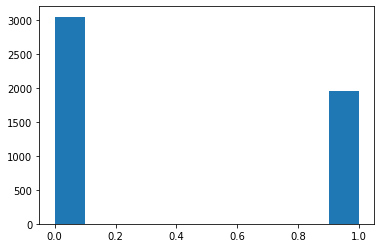

In [276]:
Y_pred = model.predict(X_test)
plt.hist(Y_pred)

In [277]:
submission = pd.DataFrame()
submission['cust_id'] = test['cust_id']
submission['predictions'] = (Y_pred).astype(int)

In [280]:
submission.to_csv('./data/DataRaiders_Submission_{}.csv'.format(count), header=False, index=False)
count+=1